# P4 Self Driving Car - Advanced Lane Finding project
In this notebook we perform an advanced lane finding pipeline including:
- Camera calibration and image undistortion
- Perspective transforms (birds-eye-view)
- Finding a thresholded binary image (using x-direction gradients and the S-channel of HSV colour-space)
- Using a histogram and sliding window technique to find the lane lines
- Faster finding of lane lines given positions from previous frames
- Lane curvature calculation
- And finally, plotting a shaded region showing the lane lines on the original images.


# Perform camera calibration

In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### Lets look at the calibration images first...

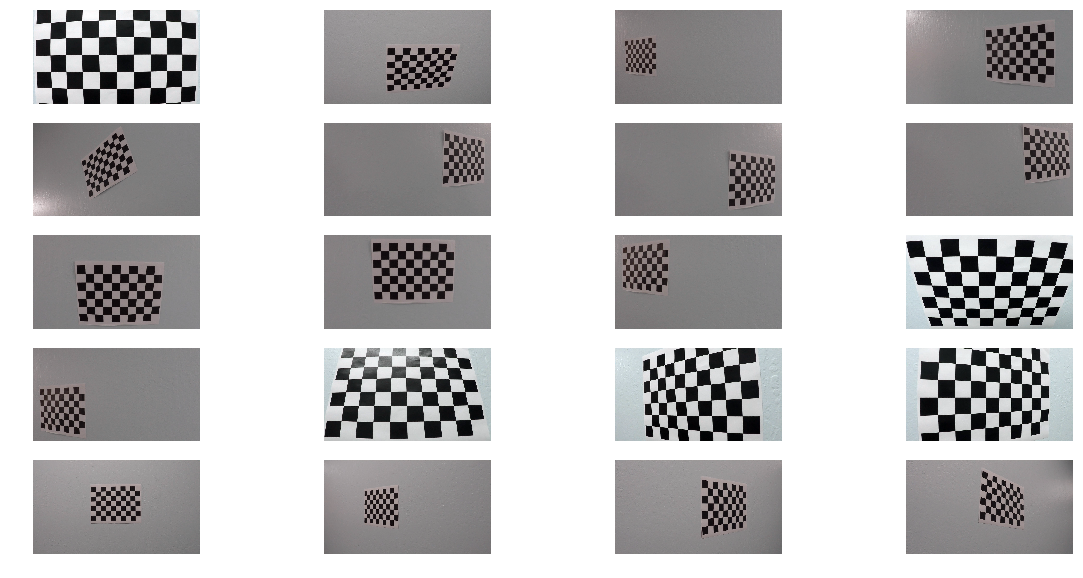

In [2]:
# Make a list of calibration images
images = glob.glob("./camera_cal/calibration*.jpg")

plt.figure(figsize=(20, 10))

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
        
    plt.subplot(len(images)//4, 4, idx+1)
    plt.imshow(img)
    plt.axis("off")

### Find the chessboard corners and display a sample
Note that some of these calibration images are not displaying the full 9 x 6 grid of corners so the corners cannot be found.<br>
Remember the distortion object and image points (objpoints, imgpoints)

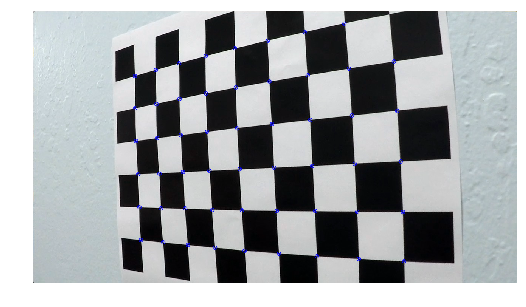

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


# Make a list of calibration images
images = glob.glob("./camera_cal/calibration*.jpg")

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        

# Lets print one example of the found corners
img = cv2.imread("camera_cal/calibration4.jpg")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
cv2.drawChessboardCorners(img, (9, 6), corners, ret)

plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.axis("off");

### Some helper functions

In [4]:
def write_image(img, file):
    """
    Write image to a file.
    
    :param img:
        RGB image
        
    :param file:
        Filename to write image to
    """
    
    bgr_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(file, bgr_img)

In [5]:
def undistort_image(img, objp, imgp):
    """
    Undistort and image based on the provided camera calibration factors.
    
    :param img:
        Image (RGB)
        
    :param objp:
        Object points calibration factors
        
    :param imgp:
        Image points calibration factors
        
    :return:
        Undistorted image
    """
    
    img_size = (img.shape[1], img.shape[0])
    
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objp, imgp, img_size, None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst

In [6]:
def warp_image(img, src, dst, image_size):
    """
    Apply perspective transformation on the provided image to gain a birds-eye-view,
    based on the source and destination image points.
    
    :param img:
        Image to transform
        
    :param: src:
        Source coordinates
        
    :param dst:
        Destination coordinates
        
    :param image_size:
        Image shape as (width, height)
        
    :returns:
        Tuple of the warped image, the transform matrix and inverse transform matrix
    """
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, image_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped, M, Minv

### Un-distort a sample camera calibration image
Using the detected corners and a set of image points, we now undistort the images to correct the camera images.

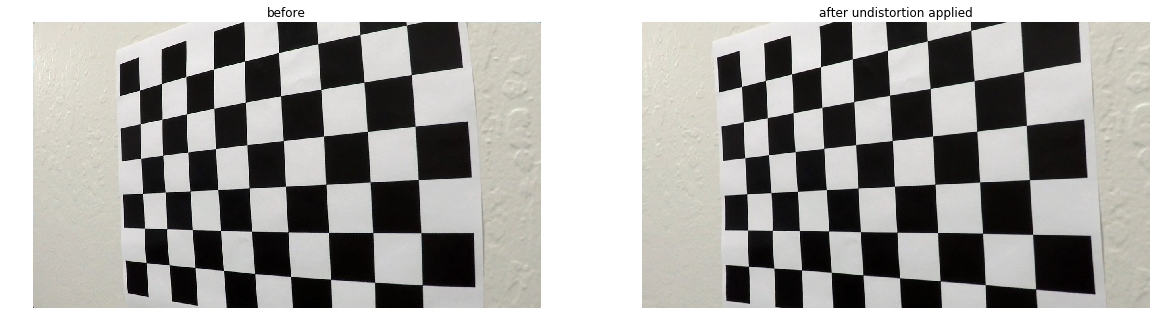

In [7]:
# Test undistortion on an image
img = cv2.imread("camera_cal/calibration4.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

dst = undistort_image(img, objpoints, imgpoints)

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("before")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(dst)
plt.title("after undistortion applied");
plt.axis("off")

write_image(dst, "output_images/camera_calibration.jpg")

### Lets undistort a test image now
Notice how the position of the white car moves...

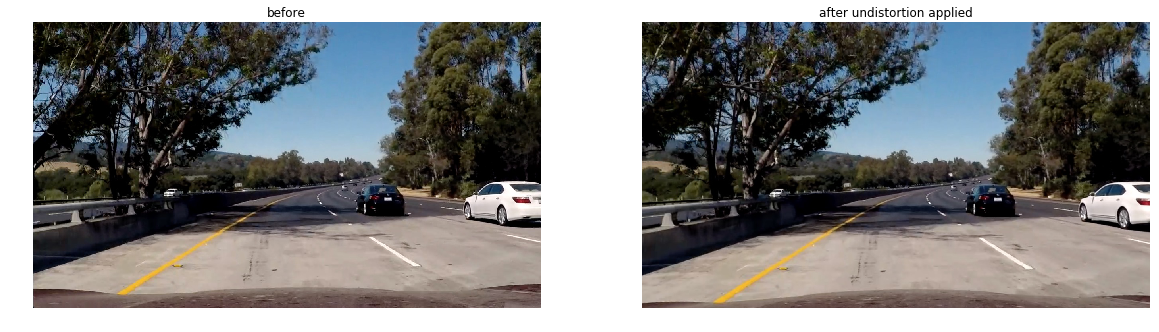

In [8]:
# Test undistortion on an image
test_img = cv2.imread("test_images/test5.jpg")
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_dst = undistort_image(test_img, objpoints, imgpoints)

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(test_img)
plt.title("before")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(test_dst)
plt.title("after undistortion applied");
plt.axis("off")

write_image(test_dst, "output_images/undistort_test_image.jpg")

# Perspective transform
Lets apply a perspective transform to the image above to get a birds eye view

### Construct source and destination points in the image for determing the perspective transform matrix
I plot the selected points below on a test image. Note that I have chosen to pick out a trapezoid region of the road looking forward (similar to how I masked out all but a trapezoid region in the first lane finding project) as the source points. Then for the detination points I have used the full rectangle of the image.

The trapezoid for the source points was determined by trial and error to nicely include the lane lines (only) looking forward into the distance.

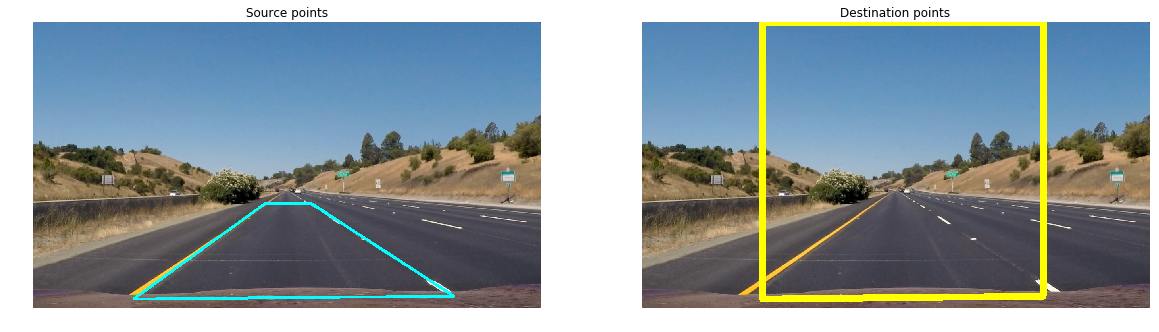

In [9]:
def get_src_dest_warp_points(image):
    """
    Computer the Source and Destination perspective transformation points.
    These points are fine-tuned to select the area within the lane lines on
    a straight/flat road such that the end result shows approximately
    parallel lines. Testing shows that these value are good for the sample
    curved sections of road as well.
    
    :param image:
        REFACTOR - not required anymore - pass in an IMAGE SHAPE instead if necessary!
    
    :return:
        Source and Destination image points to be used for a perspective transformation.
    """
    
    # Construct source and destination points as the basis for the perspective transform
    center_point = np.uint(image.shape[1]/2)
    y_top = np.uint(image.shape[0]/1.5)
    
    x_top_left = center_point - .25*np.uint(image.shape[1]/2) + 50
    x_top_right = center_point + .25*np.uint(image.shape[1]/2) - 50
    x_bottom_left = center_point - 1*np.uint(image.shape[1]/2) + 150
    y_bottom_left = np.uint(image.shape[0])
    x_bottom_right = np.uint(image.shape[1]) - 150
    
    # trapezoid following road lines
    #src = np.float32([[x_bottom_left, y_bottom_left],
    #                  [x_bottom_right, y_bottom_left],
    #                  [x_top_right, y_top],
    #                  [x_top_left, y_top]])
    #print("source points:\n", src)
    
    corners = np.float32([[253, 697], [585, 456], [700, 456], [1061, 690]])
    new_top_left = np.array([corners[0, 0], 0])
    new_top_right = np.array([corners[3, 0], 0])
    offset = [50, 0]
    
    img_size = (image.shape[1], image.shape[0])
    
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])
    
    # rectangle around entire image
    #dst = np.float32([[x_bottom_left, image.shape[0]],
    #                  [x_bottom_right, image.shape[0]],
    #                  [x_bottom_right, 0],
    #                  [x_bottom_left, 0]])
    #print("destination points:\n", dst)
    
    return src, dst


image = cv2.imread("test_images/straight_lines1.jpg")
src, dst = get_src_dest_warp_points(image)

# Plot the chosen source and destination points on the original image
points_image_src = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
points_image_dst = points_image_src.copy()


src_pts = src.reshape((-1, 1, 2)).astype("int32")
cv2.polylines(points_image_src, [src_pts], True, (0, 255, 255), thickness=5)

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(points_image_src)
plt.title("Source points")
plt.axis("off")

dst_pts = dst.reshape((-1, 1, 2)).astype("int32")
cv2.polylines(points_image_dst, [dst_pts], True, (255, 255, 0), thickness=15)

plt.subplot(1, 2, 2)
plt.imshow(points_image_dst)
plt.title("Destination points")
plt.axis("off");

### Using the src/dst image points lets warp a test image
Undistort first (we will always use undistored images from now on).

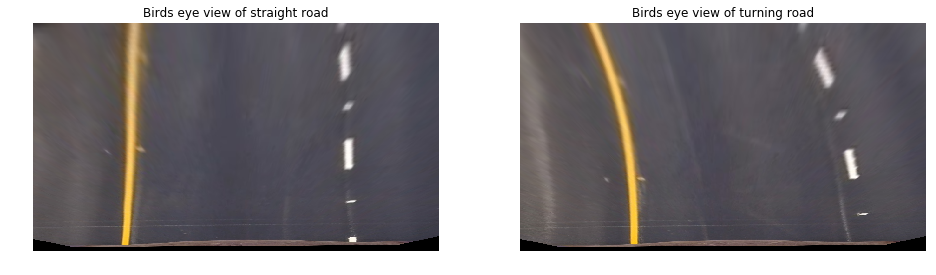

In [10]:
# Read in the same test image as used above and plot
image = cv2.imread("test_images/straight_lines1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = undistort_image(image, objpoints, imgpoints)
src, dst = get_src_dest_warp_points(image)
warped, _, _ = warp_image(image, src, dst, (image.shape[1], image.shape[0]))
write_image(warped, "output_images/warped_test_straight.jpg")

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.imshow(warped)
plt.title("Birds eye view of straight road");
plt.axis("off")

# Read in an image with straight lane lines to check the warped lines are parallel
image2 = cv2.imread("test_images/test2.jpg")
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

image2 = undistort_image(image2, objpoints, imgpoints)
warped2, _, _ = warp_image(image2, src, dst, (image2.shape[1], image2.shape[0]))
write_image(warped2, "output_images/warped_test.jpg")

plt.subplot(1, 2, 2)
plt.imshow(warped2)
plt.title("Birds eye view of turning road")
plt.axis("off");

<span style="color:green">The figure above right is the warp of an image of a stright line section of road. The fact that these lines look reasonable parallel is a sign that we are warping correctly. However I don't want to fine tune the src points to tightly as then the warp may not generalise to other road segments well...</span>

# Finding lane lines with a thresholded binary image

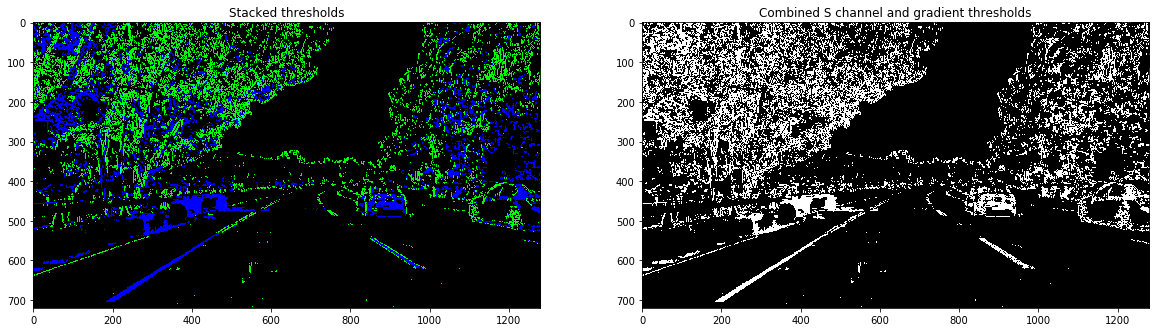

In [11]:
def thresholded_binary(undistorted_img):
    """
    Computes a binary thresholded image by first using the OpenCV Sobel
    function to take the gradient in the X direction (finds vertical lines
    better). Secondly, convert the image to the HSV colour-space and 
    threshold the S-channel.
    The result of both of these operations is combined using a bitwise-or
    to produec our binary thresholded image.
    
    :param undistorted_img:
        Source image for thresholding that has already been undistorted.
    
    :return:
        Returns a colour binary image for visualisation purposes and a
        binary thresholded image for use in lane finding.
    """
    
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2HLS).astype("float")
    s_channel = hls[:,:,2]
    
    # Sobel x
    gray = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    
    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return color_binary, combined_binary

img = cv2.imread("test_images/test5.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

undistorted_img = undistort_image(img, objpoints, imgpoints)
color_binary, combined_binary = thresholded_binary(undistorted_img)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title("Stacked thresholds")
ax1.imshow(color_binary)

ax2.set_title("Combined S channel and gradient thresholds")
ax2.imshow(combined_binary, cmap="gray");

### Apply our image distortion to get a birds-eye-view

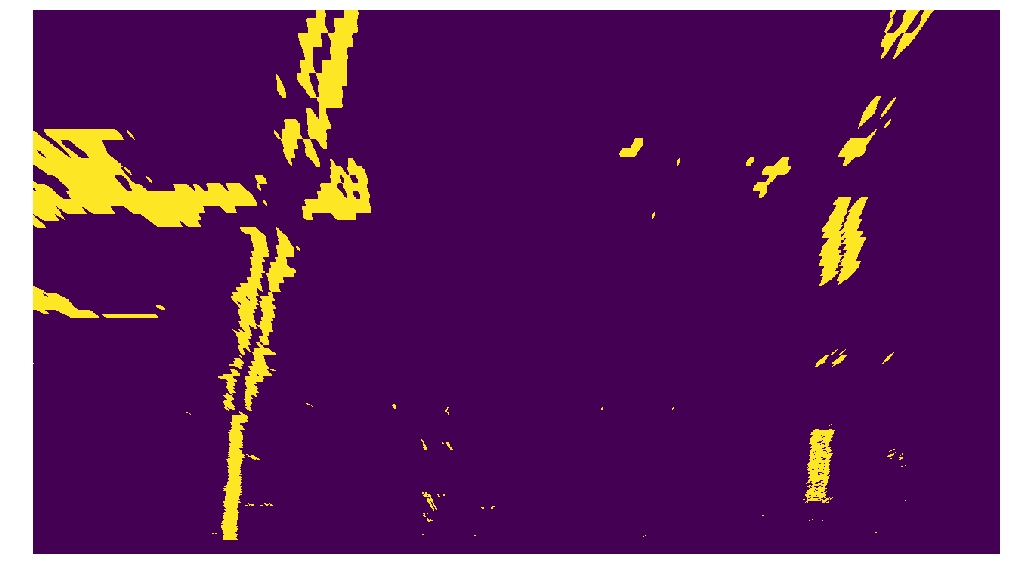

In [12]:
binary_warped, _, Minv = warp_image(combined_binary, src, dst, (image.shape[1], image.shape[0]))
plt.figure(figsize=(20,10))
plt.imshow(binary_warped)
plt.axis("off");

### Lets plot a histogram of the bottom half of the image...
The peaks will represent the most likely spots for out lane lines.

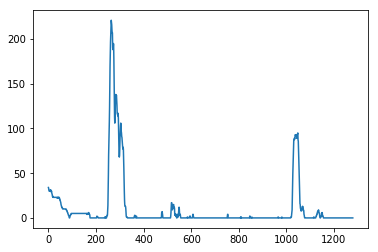

In [13]:
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
plt.plot(histogram);

### Find the lane lines and approximate them with a 2nd order polynomial.

In [14]:
def get_curvature(leftx, lefty, rightx, righty, ploty):
    y_eval = np.max(ploty)
    
    # Calculate curvature in pixel-space.
    
    #left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    ## Example values: 1926.74 1908.48
    
    # Convert from pixels to metres.
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    
    # Example values: 632.1 m    626.2 m
    
    return left_curverad, right_curverad

In [15]:
def find_lane_lines(binary_warped, debug=False):
    """
    Find left and right lane lines in the provided binary warped image by initially
    using a histogram to find the lanes line in the bottom half of the image and then
    using a sliding window techniqe to iteratively move up and finf the next part of 
    the lane lines.
    Returns the points arrays to draw each of the left and right lanes as a 2nd order
    polynonial as well as the polynomial coefficients.
    
    :param binary_warped:
        Binary image that has already been warped (perspective transformed).
    
    :param debug:
        Draw the sliding windows onto an output image.
    
    :returns:
        left_fitx - x values for plot of left lane
        right_fitx - x values for plot of right lane
        ploty - y values for plots of left and right lanes
        left_fit - 2nd order polynomial coefficients from np.polyfit for left lane
        right_fit - 2nd order polynomial coefficients from np.polyfit for right lane
    """
    
    if debug == True:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if debug == True:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 2)
            cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    l, r = get_curvature(leftx, lefty, rightx, righty, ploty)
    
    if debug == True:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        return left_fitx, right_fitx, ploty, left_fit, right_fit, l, r, out_img
    else:
        return left_fitx, right_fitx, ploty, left_fit, right_fit, l, r

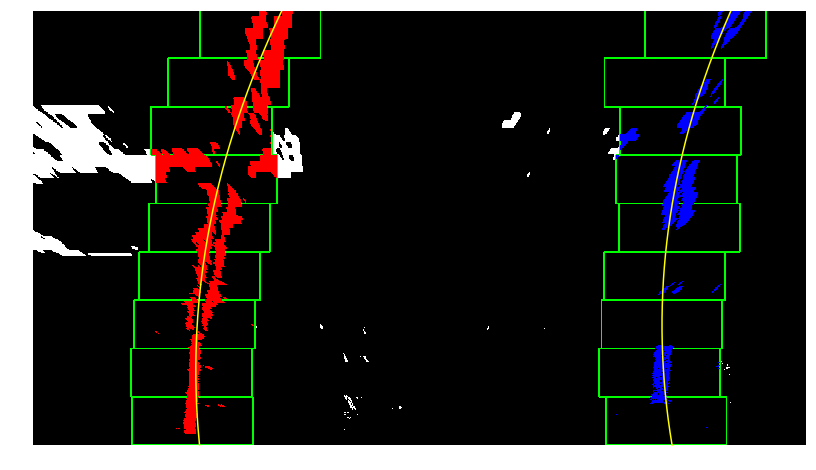

In [16]:
left_fitx, right_fitx, ploty, left_fit, right_fit, l, r, out_img = find_lane_lines(binary_warped, debug=True)

plt.figure(figsize=(16,8))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.axis("off");

### Once we know where the lanes are from the sliding window technique above we can use a faster method here by searching in a small window from where the lanes were last seen instead of blindly search across the whole width of the image...

In [17]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

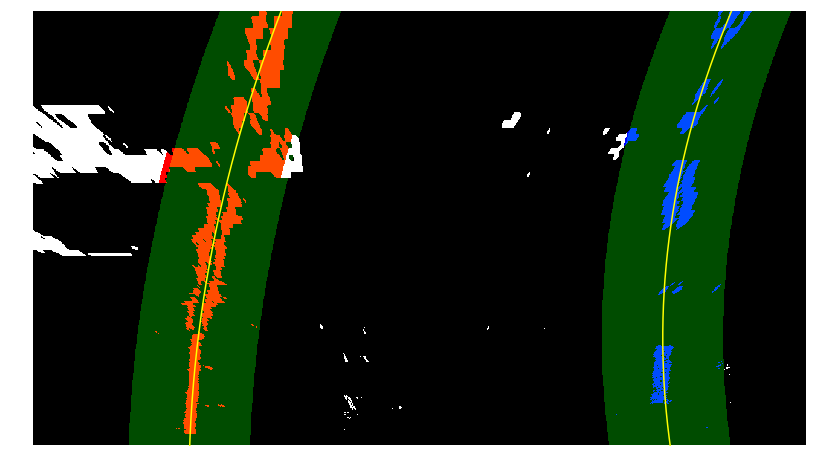

In [18]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.figure(figsize=(16,8))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.axis("off");

### Highlight the found lanes and draw on the original image

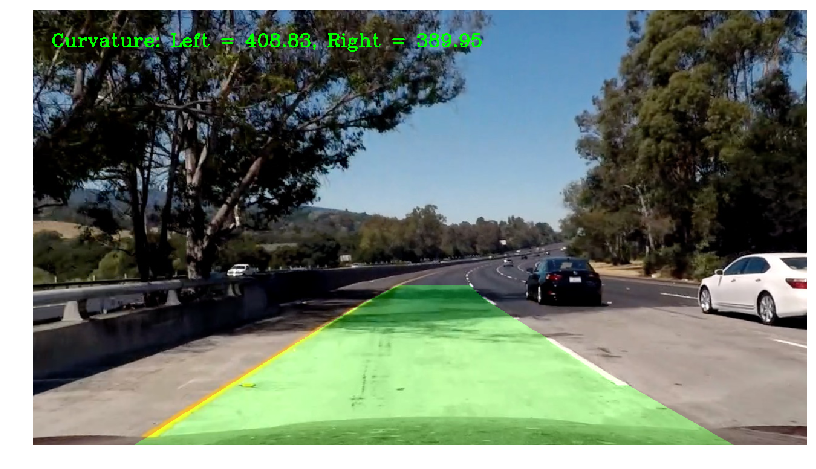

In [19]:
def draw_lanes_on_image(binary_warped, undistorted_img, Minv, left_fitx, right_fitx, ploty, left_radius, right_radius):
    """
    Draw the found lane lines onto a binary warped image, then unwarp
    and overlay on the original image.
    
    binary_warped
    Minv
    left_fitx
    right_fitx
    ploty
    """
    
    # Create a blank image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    curvature_text = "Curvature: Left = " + str(np.round(left_radius, 2)) + ", Right = " + str(np.round(right_radius, 2)) 
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, curvature_text, (30, 60), font, 1, (0,255,0), 2)
        
    return result

result = draw_lanes_on_image(binary_warped, undistorted_img, Minv, left_fitx, right_fitx, ploty, l, r)
plt.figure(figsize=(16,8))
plt.imshow(result)
plt.axis("off");

## Lets wrap the code up into an image processing pipeline that can be used on still pictures or video

In [20]:
def process_image(image):
    """
    Execute our image processing pipeline on the provided image.
    """
    undistorted = undistort_image(image, objpoints, imgpoints)
    _, combined_binary = thresholded_binary(undistorted)
    src, dst = get_src_dest_warp_points(image)
    binary_warped, _, Minv = warp_image(combined_binary, src, dst, (image.shape[1], image.shape[0]))
    left_fitx, right_fitx, ploty, _, _, l, r = find_lane_lines(binary_warped)
    lane_lines_img = draw_lanes_on_image(binary_warped, undistorted, Minv, left_fitx, right_fitx, ploty, l, r)
    return lane_lines_img

#### Run in a test image

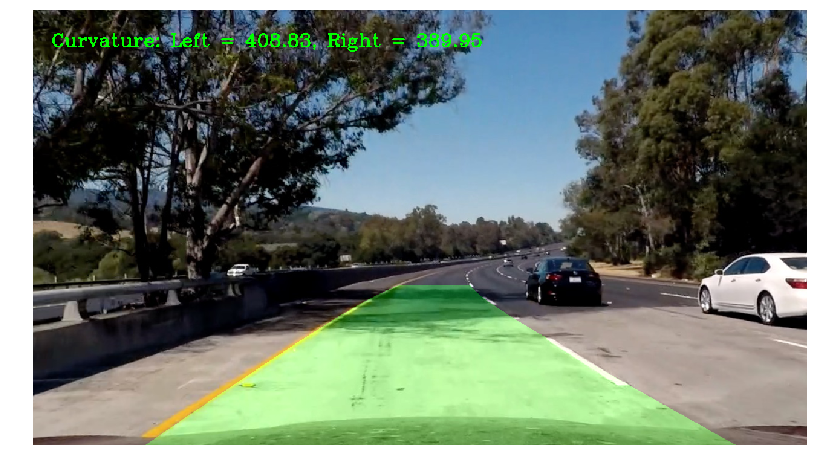

In [21]:
# Run on a test image
img = cv2.imread("test_images/test5.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result = process_image(img)

plt.figure(figsize=(16,8))
plt.imshow(result)
plt.axis("off");

#### Run on the test video
Results are very good already... Only a little bit of jitter at the concrete sections. I can fix that with some smoothing between frames.

In [22]:
video_output = "output_images/project_video_output.mp4"
clip1 = VideoFileClip("project_video.mp4")
clip1_output = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


100%|█████████▉| 1260/1261 [12:34<00:00,  1.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 12min 50s, sys: 51.2 s, total: 13min 41s
Wall time: 12min 34s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

#### Run again on the challenge video
Results on the challenge video are not so encouraging. The different road surface colouring really throws out the lane finding algorithm. Perhaps some tuning of the image thresholding could account for this.<br>
Adding in some error management so that we throw away bad lane results and smoothing between good frames would also greatly help.

In [24]:
video_challenge_output = "output_images/project_video_challenge_output.mp4"
clip1 = VideoFileClip("challenge_video.mp4")
clip1_output = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_challenge_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_challenge_output.mp4
[MoviePy] Writing video output_images/project_video_challenge_output.mp4


100%|██████████| 485/485 [04:49<00:00,  1.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_challenge_output.mp4 

CPU times: user 4min 59s, sys: 16.3 s, total: 5min 15s
Wall time: 4min 50s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_challenge_output))